In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
import numpy as np
from collections import Counter, defaultdict
import pdb
import math
import scipy
from scipy.stats import spearmanr, shapiro, ttest_ind, mannwhitneyu
import ast
from utils import load_splitsim
from IPython.display import display

In [2]:

results_dir = "results/"
predictions_dir = "predictions/"

monopolys = ['mono','poly']
poss = ['n','v'] 
sts = ['0-split','1-split','2-split']

long_to_short_model_name = {"bert-base-uncased":"bert", "bert":"bert", "bert-base-cased":"bert-cased", 
                            "xlnet-base-cased":"xlnet", "google#electra-base-discriminator":"electra", 
                            "characterbert":"bert", "bert-flota-3":"bert"} 

dataset_names = []
for mp in monopolys:
    for pos in poss:
        dataset_name = mp + "_" + pos
        dataset_names.append(dataset_name)


# (characterbert and flota are evaluated using split-types defined according to BERT's tokenization)


def method_to_legend_name(method):
    txt = method[1]
    
    if txt == "bert":
        txt = "BERT"
    
    elif txt == "characterbert":
        return "characterBERT"    
        
    elif "flota" in txt:
        txt = "FLOTA k=" + method[1].split("-")[-1] 
    
    txt += " "

    strategydict = {'average':'AVG','waverage':'WAVG','longest':'LNG', 'avg-omitfirst': 'o1',
                    'avg-omitlast': 'oL'}
    
    txt += "(" + strategydict[method[2]] + ')'
    
    if method[-1]:
        txt += " " + method[-1] + " freq"
    
    return txt

def choose_y_name(subset):     
    if subset == "bothcomplete_flota":
        y = "bothcomplete_flota_r"
    elif subset == "oneincomplete_flota":
        y = "oneincomplete_flota_r"
    elif subset == "225375":
        y = "in_freq_interval_225375_r"
    elif subset == "fasttext-all-GS": # not really a subset, but we do need a different y name.
        y = "fasttext-all-GS_r"    
    elif subset.startswith("freq_"):
        y = subset + "_r"
    else:    
        #print("no specific subset requested/understood", print(subset))
        y = 'r'
    return y



def find_best_layer_by_split(results, dataset_name, representation_type, strategy, subset=""):    
    # First load results of all layers for this specific representation type and strategy
    res = results[(results["representation_type"] == representation_type) & (results["strategy"] == strategy)]        
    y = choose_y_name(subset)
    best_layers = dict()    
    for st in ['0-split', '1-split', '2-split',"all"]:        
        st_results = [ (d['layer'], d[y]) for i, d in res.iterrows() if d['split-type'] == st]
        
        if st_results:
            best_layer = max(st_results, key=lambda item: item[1])[0]            
            best_layers[st] = best_layer
        else:            
            print(st, "unavailable", dataset_name, representation_type, strategy)            
    return best_layers




### Loading datasets and predictions 
(And picking thre best layers for every method)

In [3]:

original_datasets = dict()
all_results = dict()
all_methods = dict()
best_layers = dict()

for mp in monopolys:
    original_datasets[mp] = dict()
    all_results[mp] = dict()
    all_methods[mp] = dict()
    best_layers[mp] = dict()
    
    for pos in poss:        
        original_datasets[mp][pos] = load_splitsim(mp, pos)   
        
        
        all_results[mp][pos] = pd.read_csv(results_dir + mp + "_" + pos + "/all_results.tsv", sep="\t")
        
        dataset_name = mp + "_" + pos   
        
        representation_names = ['bert',"bert-flota-3","google#electra-base-discriminator", "xlnet-base-cased"]
        strategy_names = ["average","waverage", "longest"]
        pre_methods = list(product(representation_names, strategy_names))

        methods = [{'dataset_name':dataset_name ,"representation_type": x[0],"strategy": x[1]} for x in pre_methods]
        
        methods.append({'dataset_name':dataset_name ,"representation_type": 'bert-nocontext',"strategy": 'average'})        
        methods.append({'dataset_name':dataset_name ,"representation_type": 'google#electra-base-discriminator-nocontext',"strategy": 'average'})
        methods.append({'dataset_name':dataset_name ,"representation_type": 'xlnet-base-cased-nocontext',"strategy": 'average'})
            
        # characterbert and w2v only with average
        methods.append({'dataset_name':dataset_name, "representation_type":"characterbert","strategy":"average"}) # CharacterBERT needs no strategy, we put average by default but it won't be used
        methods.append({'dataset_name':dataset_name, "representation_type":"characterbert-nocontext","strategy":"average"})               
        
        for stra in ["avg-omitfirst","avg-omitlast"]:
            for modelname in ["bert", "google#electra-base-discriminator", "xlnet-base-cased"]:
                methods.append({'dataset_name':dataset_name, "representation_type":modelname,"strategy":stra})
                
     
        all_methods[mp][pos] = methods
                
        # Find the best layer per method on every split-type

        best_layers[mp][pos] = dict()
        subset = ""
        for method in methods:                
            bls = find_best_layer_by_split(all_results[mp][pos], dataset_name=method['dataset_name'], representation_type=method['representation_type'], strategy=method['strategy'], subset=subset)            
            best_layers[mp][pos][(method['dataset_name'], method['representation_type'], method['strategy'], subset)] = bls           
        
        

In [4]:
original_datasets['mono']['n']

,word1,pos1,word2,pos2,wup_similarity,freq1,freq2,bert_split_class,bert_split_word1,bert_split_word2,xlnet_split_class,xlnet_split_word1,xlnet_split_word2,electra_split_class,electra_split_word1,electra_split_word2,fasttext_split_class
0,peridot,n,wingspan,n,0.222222,2.50,2.81,1-split,"['per', '##ido', '##t']",['wingspan'],1-split,"['▁per', 'ido', 't']",['▁wingspan'],1-split,"['per', '##ido', '##t']",['wingspan'],0-split
1,jacinth,n,whisky,n,0.400000,1.18,3.63,1-split,"['ja', '##cin', '##th']",['whisky'],2-split,"['▁', 'jac', 'in', 'th']","['▁whisk', 'y']",1-split,"['ja', '##cin', '##th']",['whisky'],0-split
2,hello,n,periodical,n,0.117647,4.72,3.14,0-split,['hello'],['periodical'],0-split,['▁hello'],['▁periodical'],0-split,['hello'],['periodical'],0-split
3,candy,n,growl,n,0.117647,4.29,3.14,0-split,['candy'],['growl'],0-split,['▁candy'],['▁growl'],0-split,['candy'],['growl'],0-split
4,basketmaker,n,slaughterer,n,0.600000,1.29,1.52,2-split,"['basket', '##maker']","['slaughter', '##er']",2-split,"['▁basket', 'maker']","['▁slaughter', 'er']",2-split,"['basket', '##maker']","['slaughter', '##er']",0-split
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67495,moth,n,shaman,n,0.521739,3.50,3.22,0-split,['moth'],['shaman'],0-split,['▁moth'],['▁shaman'],0-split,['moth'],['shaman'],0-split
67496,bulimic,n,macrophage,n,0.526316,2.21,2.44,2-split,"['bu', '##lim', '##ic']","['macro', '##pha', '##ge']",2-split,"['▁', 'bul', 'im', 'ic']","['▁macro', 'ph', 'age']",2-split,"['bu', '##lim', '##ic']","['macro', '##pha', '##ge']",0-split
67497,bartender,n,few,n,0.133333,3.50,5.60,0-split,['bartender'],['few'],0-split,['▁bartender'],['▁few'],0-split,['bartender'],['few'],0-split
67498,industrialisation,n,scamper,n,0.476190,2.70,2.36,2-split,"['industrial', '##isation']","['sc', '##amp', '##er']",2-split,"['▁industrial', 'isation']","['▁scam', 'per']",2-split,"['industrial', '##isation']","['sc', '##amp', '##er']",0-split


## Table 6: Global results on each SPLIT-SIM subset

In [5]:

for mp, pos in [("mono","n"), ("mono","v"),("poly", "n"),("poly","v")]:
    print("Global results for", mp, pos)
    global_results = []
    for method in best_layers[mp][pos]:
        _, representation_type, strategy, subset = method
        if "omit" in strategy or "nocontext" in representation_type:
            continue
        res = all_results[mp][pos]
        res_this_method = res[(res["representation_type"] == representation_type) & (res["strategy"] == strategy)]    
        st = "all"
        result = [r for i, r in res_this_method.iterrows() if r['split-type'] == st and r['layer'] == best_layers[mp][pos][method][st]]
        if not result or len(result) > 1:
            print("Result is either not available or duplicated")
            pdb.set_trace()
        else:
            result = result[0]
        #result['method'] = method            
        global_results.append(result)

    global_results = pd.DataFrame(global_results)
    global_results = global_results[["representation_type","strategy","r","layer","split-type"]]
    global_results = global_results.round({'r':2})
    global_results.sort_values(by="r", ascending=False)
    
    display(global_results)

Global results for mono n


,representation_type,strategy,r,layer,split-type
419,bert,average,0.38,6,all
527,bert,waverage,0.38,6,all
343,bert,longest,0.31,8,all
935,bert-flota-3,average,0.35,5,all
703,bert-flota-3,waverage,0.35,6,all
887,bert-flota-3,longest,0.30,8,all
1495,google#electra-base-discriminator,average,0.39,5,all
1583,google#electra-base-discriminator,waverage,0.40,5,all
1407,google#electra-base-discriminator,longest,0.35,5,all
175,xlnet-base-cased,average,0.41,10,all


Global results for mono v


,representation_type,strategy,r,layer,split-type
539,bert,average,0.33,11,all
511,bert,waverage,0.33,11,all
455,bert,longest,0.31,12,all
635,bert-flota-3,average,0.27,12,all
683,bert-flota-3,waverage,0.28,12,all
799,bert-flota-3,longest,0.25,12,all
1487,google#electra-base-discriminator,average,0.34,5,all
1631,google#electra-base-discriminator,waverage,0.35,3,all
1611,google#electra-base-discriminator,longest,0.28,5,all
75,xlnet-base-cased,average,0.36,4,all


Global results for poly n


,representation_type,strategy,r,layer,split-type
367,bert,average,0.30,10,all
363,bert,waverage,0.30,12,all
415,bert,longest,0.28,12,all
743,bert-flota-3,average,0.24,12,all
747,bert-flota-3,waverage,0.24,12,all
927,bert-flota-3,longest,0.21,12,all
1587,google#electra-base-discriminator,average,0.27,8,all
1535,google#electra-base-discriminator,waverage,0.28,8,all
1399,google#electra-base-discriminator,longest,0.26,7,all
283,xlnet-base-cased,average,0.29,7,all


Global results for poly v


,representation_type,strategy,r,layer,split-type
367,bert,average,0.30,10,all
363,bert,waverage,0.30,12,all
415,bert,longest,0.28,12,all
743,bert-flota-3,average,0.24,12,all
747,bert-flota-3,waverage,0.24,12,all
927,bert-flota-3,longest,0.21,12,all
1587,google#electra-base-discriminator,average,0.27,8,all
1535,google#electra-base-discriminator,waverage,0.28,8,all
1399,google#electra-base-discriminator,longest,0.26,7,all
283,xlnet-base-cased,average,0.29,7,all


In [6]:

def plot_comparison_best_layer(results, best_layers):  
    results_to_plot = []
    for method in best_layers: 
        dataset_name, representation_type, strategy, subset = method        
        y = choose_y_name(subset)
        res_this_method = results[(results["representation_type"] == representation_type) & (results["strategy"] == strategy)]    
        for st in ['0-split','1-split','2-split']:
            result = [r for i, r in res_this_method.iterrows() if r['split-type'] == st and r['layer'] == best_layers[method][st]][0]
            result['method'] = method
            result["Spearman's rho"] = result[y] 
            result['legend'] = method_to_legend_name(method)
            results_to_plot.append(result)
    results_to_plot = pd.DataFrame(results_to_plot)
    results_to_plot = results_to_plot[["representation_type","strategy","Spearman's rho","layer","split-type"]]
    results_to_plot = results_to_plot.round({'r':2})
    return results_to_plot


# Table 7: results by subset, split-type, strategy and representation type
#### Full SPLIT-SIM. WUP similarity


In [7]:
results_by_st = dict()
most_res = dict()
for dn in dataset_names: 
    mp, pos = dn.split("_")
    most_res[dn] = plot_comparison_best_layer(all_results[mp][pos], best_layers[mp][pos])    

    print('Results for', dn)
    results_by_st[dn] = pd.DataFrame([r for i, r in most_res[dn].iterrows() if not 'omit' in r['strategy'] and not 'nocontext' in r['representation_type']])
    
    display(results_by_st[dn])
    

Results for mono_n


,representation_type,strategy,Spearman's rho,layer,split-type
416,bert,average,0.486962,6,0-split
417,bert,average,0.413463,6,1-split
506,bert,average,0.431153,10,2-split
524,bert,waverage,0.486962,6,0-split
525,bert,waverage,0.384668,6,1-split
402,bert,waverage,0.403573,10,2-split
600,bert,longest,0.486962,6,0-split
341,bert,longest,0.280946,8,1-split
322,bert,longest,0.264195,10,2-split
836,bert-flota-3,average,0.488215,6,0-split


Results for mono_v


,representation_type,strategy,Spearman's rho,layer,split-type
480,bert,average,0.434704,1,0-split
569,bert,average,0.329787,12,1-split
538,bert,average,0.411248,11,2-split
376,bert,waverage,0.434704,1,0-split
477,bert,waverage,0.334070,12,1-split
510,bert,waverage,0.403303,11,2-split
360,bert,longest,0.434704,1,0-split
453,bert,longest,0.259267,12,1-split
454,bert,longest,0.323845,12,2-split
884,bert-flota-3,average,0.434888,1,0-split


Results for poly_n


,representation_type,strategy,Spearman's rho,layer,split-type
320,bert,average,0.370687,2,0-split
593,bert,average,0.340814,12,1-split
594,bert,average,0.325259,12,2-split
312,bert,waverage,0.370687,2,0-split
361,bert,waverage,0.330542,12,1-split
362,bert,waverage,0.307767,12,2-split
516,bert,longest,0.370687,2,0-split
413,bert,longest,0.254360,12,1-split
414,bert,longest,0.241592,12,2-split
920,bert-flota-3,average,0.369558,2,0-split


Results for poly_v


,representation_type,strategy,Spearman's rho,layer,split-type
320,bert,average,0.370687,2,0-split
593,bert,average,0.340814,12,1-split
594,bert,average,0.325259,12,2-split
312,bert,waverage,0.370687,2,0-split
361,bert,waverage,0.330542,12,1-split
362,bert,waverage,0.307767,12,2-split
516,bert,longest,0.370687,2,0-split
413,bert,longest,0.254360,12,1-split
414,bert,longest,0.241592,12,2-split
920,bert-flota-3,average,0.369558,2,0-split


## Table 7 significance testing

Significant comparisons are printed out

In [8]:
# info from https://www.ibm.com/support/pages/differences-between-correlations

def calculate_significance(rs, cs):
    pairs = [('0-split','1-split'),('1-split','2-split'),('2-split','0-split')]    
    for p1, p2 in pairs: 
        z1 = .5*math.log((1+rs[p1])/(1-rs[p1])) # Fisher transformation
        z2 = .5*math.log((1+rs[p2])/(1-rs[p2])) # Fisher transformation
        sezdiff = math.sqrt(1.06/(cs[p1]-3)+ 1.06/(cs[p2]-3))        
        ztest = (z1-z2)/sezdiff
        pval = scipy.stats.norm.sf(abs(ztest)) 
        if pval < 0.05:
            print("p value for the comparison", p1, "vs", p2, "is significant")
        


In [9]:

for dn in dataset_names: 
    print()
    print("******", dn.upper(), "******")
    mp, pos = dn.split("_")
    cs_bert = Counter(original_datasets[mp][pos]['bert_split_class'])    
    cs_xlnet = Counter(original_datasets[mp][pos]['xlnet_split_class'])        
    subset = ""    
    for method in all_methods[mp][pos]:           
        rs = dict()
        if not "context" in method['representation_type'] and method['strategy'] in ['average','waverage','longest']:            
            bls = best_layers[mp][pos][(method['dataset_name'], method['representation_type'], method['strategy'], subset)]
            for i, r in all_results[mp][pos].iterrows():
                if r['representation_type'] == method['representation_type'] and r['strategy'] == method['strategy'] and r['layer'] == bls[r['split-type']]:
                    rs[r['split-type']] = r['r'] 
            
            print(method['representation_type'], method['strategy'])
            if "xlnet" in method['representation_type']:
                calculate_significance(rs, cs_xlnet)
            else:
                calculate_significance(rs, cs_bert)
            print()
    


****** MONO_N ******
bert average
p value for the comparison 0-split vs 1-split is significant
p value for the comparison 1-split vs 2-split is significant
p value for the comparison 2-split vs 0-split is significant

bert waverage
p value for the comparison 0-split vs 1-split is significant
p value for the comparison 1-split vs 2-split is significant
p value for the comparison 2-split vs 0-split is significant

bert longest
p value for the comparison 0-split vs 1-split is significant
p value for the comparison 1-split vs 2-split is significant
p value for the comparison 2-split vs 0-split is significant

bert-flota-3 average
p value for the comparison 0-split vs 1-split is significant
p value for the comparison 2-split vs 0-split is significant

bert-flota-3 waverage
p value for the comparison 0-split vs 1-split is significant
p value for the comparison 2-split vs 0-split is significant

bert-flota-3 longest
p value for the comparison 0-split vs 1-split is significant
p value for the

## TABLE 8: FLOTA-specific analysis
Comparing FLOTA results on pairs where words were fully preserved (COM) vs where at least one word had a portion omitted (INCM)


In [10]:
for dn in dataset_names:
    results = []
    mp, pos = dn.split("_")    
    print("******", dn.upper(), "******")
    for method in best_layers[mp][pos]:
        if "bert-flota-3" in method:                            
            for st in ['1-split','2-split']:                                
                bl = best_layers[mp][pos][method][st]
                res = [r for i, r in all_results[mp][pos].iterrows() if r['representation_type'] == method[1] and r['strategy'] == method[2] and r['split-type'] == st and r['layer'] == bl]
                results.append(res[0])
                
                           
    results = pd.DataFrame(results)
    results = results[["representation_type","strategy","bothcomplete_flota_r","oneincomplete_flota_r","split-type"]]
    results = results.round({'bothcomplete_flota_r':2, "oneincomplete_flota_r":2})
    display(results)
                
                
                

****** MONO_N ******


,representation_type,strategy,bothcomplete_flota_r,oneincomplete_flota_r,split-type
837,bert-flota-3,average,0.36,0.30,1-split
910,bert-flota-3,average,0.31,0.41,2-split
701,bert-flota-3,waverage,0.33,0.30,1-split
826,bert-flota-3,waverage,0.29,0.40,2-split
733,bert-flota-3,longest,0.26,0.30,1-split
734,bert-flota-3,longest,0.20,0.28,2-split


****** MONO_V ******


,representation_type,strategy,bothcomplete_flota_r,oneincomplete_flota_r,split-type
633,bert-flota-3,average,0.22,0.25,1-split
730,bert-flota-3,average,0.23,0.32,2-split
681,bert-flota-3,waverage,0.23,0.22,1-split
682,bert-flota-3,waverage,0.24,0.31,2-split
797,bert-flota-3,longest,0.20,0.03,1-split
798,bert-flota-3,longest,0.22,0.27,2-split


****** POLY_N ******


,representation_type,strategy,bothcomplete_flota_r,oneincomplete_flota_r,split-type
741,bert-flota-3,average,0.26,0.16,1-split
698,bert-flota-3,average,0.17,0.09,2-split
745,bert-flota-3,waverage,0.24,0.09,1-split
706,bert-flota-3,waverage,0.17,0.07,2-split
925,bert-flota-3,longest,0.19,-0.02,1-split
926,bert-flota-3,longest,0.15,0.07,2-split


****** POLY_V ******


,representation_type,strategy,bothcomplete_flota_r,oneincomplete_flota_r,split-type
741,bert-flota-3,average,0.26,0.16,1-split
698,bert-flota-3,average,0.17,0.09,2-split
745,bert-flota-3,waverage,0.24,0.09,1-split
706,bert-flota-3,waverage,0.17,0.07,2-split
925,bert-flota-3,longest,0.19,-0.02,1-split
926,bert-flota-3,longest,0.15,0.07,2-split


# Table 9: Results on balanced version of SPLIT-SIM

In [11]:
balanced_splitsim_results = dict()

best_layers_freq = dict()

for dn in dataset_names:
    best_layers_freq[dn] = dict()
    mp, pos = dn.split("_")
    subset = "225375" 
    for method in all_methods[mp][pos]:
        bls = find_best_layer_by_split(all_results[mp][pos], dataset_name=method['dataset_name'], representation_type=method['representation_type'], strategy=method['strategy'], subset=subset)    
        best_layers_freq[dn][(method['dataset_name'], method['representation_type'], method['strategy'], subset)] = bls

    balanced_splitsim_results[dn] = plot_comparison_best_layer(all_results[mp][pos], best_layers_freq[dn])  
    balanced_splitsim_results[dn] = pd.DataFrame([r for i, r in balanced_splitsim_results[dn].iterrows() if not "context" in r['representation_type'] and not "flota" in r['representation_type'] and r['strategy'] == "average"])
    
    print("Results for", dn)
    display(balanced_splitsim_results[dn])
    


Results for mono_n


,representation_type,strategy,Spearman's rho,layer,split-type
416,bert,average,0.516811,6,0-split
417,bert,average,0.465142,6,1-split
614,bert,average,0.438391,7,2-split
1460,google#electra-base-discriminator,average,0.526992,3,0-split
1493,google#electra-base-discriminator,average,0.486959,5,1-split
1494,google#electra-base-discriminator,average,0.481433,5,2-split
268,xlnet-base-cased,average,0.568879,3,0-split
201,xlnet-base-cased,average,0.531754,4,1-split
202,xlnet-base-cased,average,0.494760,4,2-split
1280,characterbert,average,0.518511,4,0-split


Results for mono_v


,representation_type,strategy,Spearman's rho,layer,split-type
480,bert,average,0.525929,1,0-split
429,bert,average,0.387707,7,1-split
538,bert,average,0.423928,11,2-split
1460,google#electra-base-discriminator,average,0.595372,1,0-split
1485,google#electra-base-discriminator,average,0.310648,5,1-split
1554,google#electra-base-discriminator,average,0.398465,3,2-split
248,xlnet-base-cased,average,0.708441,1,0-split
73,xlnet-base-cased,average,0.464864,4,1-split
74,xlnet-base-cased,average,0.359723,4,2-split
1260,characterbert,average,0.536211,4,0-split


Results for poly_n


,representation_type,strategy,Spearman's rho,layer,split-type
484,bert,average,0.459132,11,0-split
341,bert,average,0.394531,6,1-split
594,bert,average,0.385502,12,2-split
1644,google#electra-base-discriminator,average,0.461441,4,0-split
1645,google#electra-base-discriminator,average,0.435279,4,1-split
1446,google#electra-base-discriminator,average,0.400999,5,2-split
72,xlnet-base-cased,average,0.476628,6,0-split
157,xlnet-base-cased,average,0.457525,4,1-split
158,xlnet-base-cased,average,0.395728,4,2-split
1256,characterbert,average,0.457707,4,0-split


Results for poly_v


,representation_type,strategy,Spearman's rho,layer,split-type
484,bert,average,0.459132,11,0-split
341,bert,average,0.394531,6,1-split
594,bert,average,0.385502,12,2-split
1644,google#electra-base-discriminator,average,0.461441,4,0-split
1645,google#electra-base-discriminator,average,0.435279,4,1-split
1446,google#electra-base-discriminator,average,0.400999,5,2-split
72,xlnet-base-cased,average,0.476628,6,0-split
157,xlnet-base-cased,average,0.457525,4,1-split
158,xlnet-base-cased,average,0.395728,4,2-split
1256,characterbert,average,0.457707,4,0-split


In [12]:
for dn in dataset_names: 
    print()
    print("******", dn.upper(), "******")
    mp, pos = dn.split("_")
    d = original_datasets[mp][pos]
    in_interval = pd.DataFrame([r for i, r in d.iterrows() if 2.25 <= r["freq1"] < 3.75 and 2.25 <= r["freq2"] < 3.75])
    cs_bert = Counter(in_interval['bert_split_class'])    
    cs_xlnet = Counter(in_interval['xlnet_split_class']) 
    subset = "225375"    
    for method in all_methods[mp][pos]:           
        rs = dict()
        if not "context" in method['representation_type'] and method['strategy'] == 'average':            
            bls = best_layers_freq[dn][(method['dataset_name'], method['representation_type'], method['strategy'], subset)]
            for i, r in all_results[mp][pos].iterrows():
                if r['representation_type'] == method['representation_type'] and r['strategy'] == method['strategy'] and r['layer'] == bls[r['split-type']]:
                    rs[r['split-type']] = r['in_freq_interval_225375_r'] 
            
            print(method['representation_type'], method['strategy'])
            if "xlnet" in method['representation_type']:
                calculate_significance(rs, cs_xlnet)
            else:
                calculate_significance(rs, cs_bert)
            print()            


****** MONO_N ******
bert average
p value for the comparison 0-split vs 1-split is significant
p value for the comparison 2-split vs 0-split is significant

bert-flota-3 average
p value for the comparison 0-split vs 1-split is significant
p value for the comparison 1-split vs 2-split is significant
p value for the comparison 2-split vs 0-split is significant

google#electra-base-discriminator average
p value for the comparison 0-split vs 1-split is significant
p value for the comparison 2-split vs 0-split is significant

xlnet-base-cased average
p value for the comparison 0-split vs 1-split is significant
p value for the comparison 1-split vs 2-split is significant
p value for the comparison 2-split vs 0-split is significant

characterbert average
p value for the comparison 0-split vs 1-split is significant
p value for the comparison 2-split vs 0-split is significant


****** MONO_V ******
bert average

bert-flota-3 average
p value for the comparison 0-split vs 1-split is significant


In [13]:
[k for k in best_layers_freq if k[0] == "mono_n"]

[]

# Table 10: Results on pairs with low and high frequency

In [14]:

chosen_interval_thresholds = dict()

chosen_interval_thresholds['mono_n'] = dict()
chosen_interval_thresholds['mono_n']['0-split'] = 3.5
chosen_interval_thresholds['mono_n']['1-split'] = 3
chosen_interval_thresholds['mono_n']['2-split'] = 1.75

chosen_interval_thresholds['poly_n'] = dict()
chosen_interval_thresholds['poly_n']['0-split'] = 3.75
chosen_interval_thresholds['poly_n']['1-split'] = 3.25
chosen_interval_thresholds['poly_n']['2-split'] = 2.25

chosen_interval_thresholds['poly_v'] = dict()
chosen_interval_thresholds['poly_v']['0-split'] = 4
chosen_interval_thresholds['poly_v']['1-split'] = 3.25
chosen_interval_thresholds['poly_v']['2-split'] = 2.5



def plot_comparison_best_layer_individual_thresholds(results, thresholds):    
    ind_freq_results = dict()    
    for dn in thresholds:
        mp, pos = dn.split("_")
        ind_freq_results[dn] = [] 
        for st in thresholds[dn]:
            t = thresholds[dn][st]            
            for loworhigh in ['lower', 'higher']:            
                subset = "freq_" + loworhigh + "_interval_" + str(t)                                             
                for method in methods:  
                    method_tuple = (method['representation_type'], method['strategy'])
                    bls = find_best_layer_by_split(all_results[mp][pos], dataset_name=method['dataset_name'], representation_type=method['representation_type'], strategy=method['strategy'], subset=subset)    
                    bls = bls[st]
                    
                    ss = [r for i, r in all_results[mp][pos].iterrows() if r['representation_type'] == method['representation_type'] 
                          and r['strategy'] == method['strategy'] and r['split-type'] == st and r['layer'] == bls]
                    
                    ind_freq_results[dn].append({'freq':loworhigh, 'split-type':st, 'representation_type':method_tuple[0], 'strategy':method_tuple[1] , 'r':ss[0][choose_y_name(subset)], 'layer':bls})
                    

    return ind_freq_results
            
            




In [15]:

ind_freq_results_da_interval = plot_comparison_best_layer_individual_thresholds(all_results, chosen_interval_thresholds)
    

#### With context

In [16]:

for dn in ind_freq_results_da_interval:
    print(dn)
    df = pd.DataFrame(ind_freq_results_da_interval[dn])
    df = pd.DataFrame([r for i, r in df.iterrows() if r['strategy'] == "average" and "nocontext" not in r['representation_type'] and "flota" not in r['representation_type']])
    df = df.round({'r':2})
    display(df)


mono_n


,freq,split-type,representation_type,strategy,r,layer
0,lower,0-split,bert,average,0.52,6
6,lower,0-split,google#electra-base-discriminator,average,0.52,3
9,lower,0-split,xlnet-base-cased,average,0.59,4
15,lower,0-split,characterbert,average,0.51,4
23,higher,0-split,bert,average,0.52,6
29,higher,0-split,google#electra-base-discriminator,average,0.51,3
32,higher,0-split,xlnet-base-cased,average,0.53,2
38,higher,0-split,characterbert,average,0.51,4
46,lower,1-split,bert,average,0.44,6
52,lower,1-split,google#electra-base-discriminator,average,0.47,6


poly_n


,freq,split-type,representation_type,strategy,r,layer
0,lower,0-split,bert,average,0.43,11
6,lower,0-split,google#electra-base-discriminator,average,0.42,3
9,lower,0-split,xlnet-base-cased,average,0.47,4
15,lower,0-split,characterbert,average,0.40,9
23,higher,0-split,bert,average,0.39,2
29,higher,0-split,google#electra-base-discriminator,average,0.38,0
32,higher,0-split,xlnet-base-cased,average,0.35,6
38,higher,0-split,characterbert,average,0.35,11
46,lower,1-split,bert,average,0.47,6
52,lower,1-split,google#electra-base-discriminator,average,0.48,6


poly_v


,freq,split-type,representation_type,strategy,r,layer
0,lower,0-split,bert,average,0.40,12
6,lower,0-split,google#electra-base-discriminator,average,0.41,3
9,lower,0-split,xlnet-base-cased,average,0.48,4
15,lower,0-split,characterbert,average,0.39,9
23,higher,0-split,bert,average,0.39,2
29,higher,0-split,google#electra-base-discriminator,average,0.39,0
32,higher,0-split,xlnet-base-cased,average,0.38,0
38,higher,0-split,characterbert,average,0.38,10
46,lower,1-split,bert,average,0.47,6
52,lower,1-split,google#electra-base-discriminator,average,0.48,6


#### Without context

In [17]:
for dn in ind_freq_results_da_interval:
    print(dn)
    df = pd.DataFrame(ind_freq_results_da_interval[dn])
    df = pd.DataFrame([r for i, r in df.iterrows() if r['strategy'] == "average" and "nocontext" in r['representation_type'] and "flota" not in r['representation_type']])
    df = df.round({'r':2})
    display(df)


mono_n


,freq,split-type,representation_type,strategy,r,layer
12,lower,0-split,bert-nocontext,average,0.37,1
13,lower,0-split,google#electra-base-discriminator-nocontext,average,0.45,0
14,lower,0-split,xlnet-base-cased-nocontext,average,0.58,0
16,lower,0-split,characterbert-nocontext,average,0.44,1
35,higher,0-split,bert-nocontext,average,0.43,0
36,higher,0-split,google#electra-base-discriminator-nocontext,average,0.49,0
37,higher,0-split,xlnet-base-cased-nocontext,average,0.51,0
39,higher,0-split,characterbert-nocontext,average,0.46,1
58,lower,1-split,bert-nocontext,average,0.24,5
59,lower,1-split,google#electra-base-discriminator-nocontext,average,0.30,0


poly_n


,freq,split-type,representation_type,strategy,r,layer
12,lower,0-split,bert-nocontext,average,0.26,1
13,lower,0-split,google#electra-base-discriminator-nocontext,average,0.34,0
14,lower,0-split,xlnet-base-cased-nocontext,average,0.41,0
16,lower,0-split,characterbert-nocontext,average,0.28,1
35,higher,0-split,bert-nocontext,average,0.31,1
36,higher,0-split,google#electra-base-discriminator-nocontext,average,0.41,0
37,higher,0-split,xlnet-base-cased-nocontext,average,0.35,0
39,higher,0-split,characterbert-nocontext,average,0.34,0
58,lower,1-split,bert-nocontext,average,0.34,4
59,lower,1-split,google#electra-base-discriminator-nocontext,average,0.29,3


poly_v


,freq,split-type,representation_type,strategy,r,layer
12,lower,0-split,bert-nocontext,average,0.29,1
13,lower,0-split,google#electra-base-discriminator-nocontext,average,0.36,0
14,lower,0-split,xlnet-base-cased-nocontext,average,0.44,0
16,lower,0-split,characterbert-nocontext,average,0.29,1
35,higher,0-split,bert-nocontext,average,0.34,2
36,higher,0-split,google#electra-base-discriminator-nocontext,average,0.41,0
37,higher,0-split,xlnet-base-cased-nocontext,average,0.38,0
39,higher,0-split,characterbert-nocontext,average,0.32,0
58,lower,1-split,bert-nocontext,average,0.34,4
59,lower,1-split,google#electra-base-discriminator-nocontext,average,0.29,3


# Figure 2: plots by layer
Given a specific method, print results obtained by every layer, separated by split-type

In [18]:
def map_datasetnames(dn):
    mp, pos = dn.split("_")
    return mp[0].upper() + "-" + pos.upper()


def plot_splits_across_layers(original_dataset, results, dataset_name, representation_type, strategy, subset=""):
    
    results_to_plot = results[(results["representation_type"] == representation_type) & (results["strategy"] == strategy)]
    results_to_plot = results_to_plot[results_to_plot['split-type'] != "all"] 
    
    for i, r in results_to_plot.iterrows():
        results_to_plot.at[i,'split-type'] = r['split-type'].upper()
        
    sns.color_palette("hls", 8)    
    
    y = choose_y_name(subset)
    plt.figure(figsize=(5,4))
    
    g = sns.lineplot(x="layer", y=y, hue="split-type", data=results_to_plot, markers=True, style="split-type", linewidth = 2, markersize=8)

    g.set(ylim=(0, 0.55))
    
    method = (dataset_name, representation_type, strategy, subset)
    methodname = method_to_legend_name(method)
    
    g.set_title(map_datasetnames(dataset_name), fontsize=16)
    plt.xlabel("Layer", fontsize=16);
    plt.ylabel("Spearman's rho", fontsize=16);    
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.xticks(range(0,13,2)) 
    plt.yticks([0.0,0.1,0.2,0.3,0.4,0.5]) 
    plt.grid(True)
    plt.legend(loc='lower right', fontsize=17)
    plt.show()
    return results_to_plot
  



mono_n


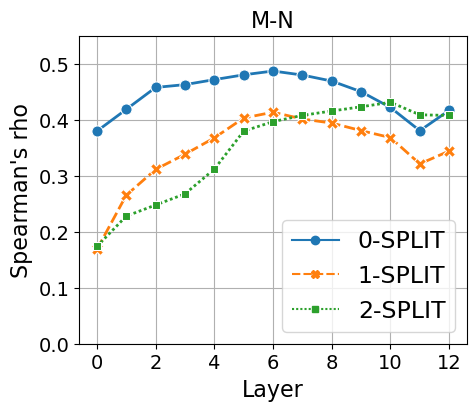

mono_v


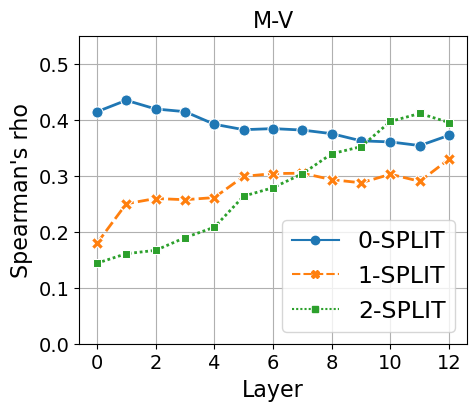

poly_n


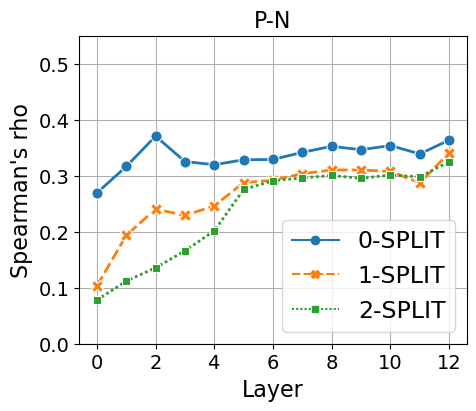

poly_v


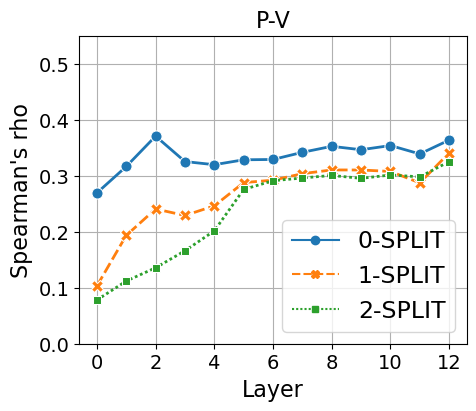

In [19]:

for dn in dataset_names:
    print(dn)
    mp, pos = dn.split("_")

    _ = plot_splits_across_layers(original_datasets[mp][pos], all_results[mp][pos], dataset_name=dn, representation_type="bert", strategy="average", subset="")
    
    

In [20]:
all_results['poly']['v']

,layer,representation_type,strategy,split-type,r,p,fasttext-all-GS_r,in_freq_interval_225375_r,freq_lower_interval_1.5_r,freq_higher_interval_1.5_r,...,freq_lower_interval_3.5_r,freq_higher_interval_3.5_r,freq_lower_interval_3.75_r,freq_higher_interval_3.75_r,freq_lower_interval_4_r,freq_higher_interval_4_r,freq_lower_interval_4.25_r,freq_higher_interval_4.25_r,bothcomplete_flota_r,oneincomplete_flota_r
0,9,xlnet-base-cased,avg-omitfirst,0-split,0.294487,1.223888e-112,0.438791,0.366345,NaN,0.298351,...,0.393939,0.274421,0.375063,0.267104,0.343328,0.280696,0.316465,0.292903,NaN,NaN
1,9,xlnet-base-cased,avg-omitfirst,1-split,0.262470,3.409581e-95,0.399555,0.337909,NaN,0.319446,...,0.321256,0.348588,0.314684,0.376464,0.316606,0.470993,0.315806,0.642490,NaN,NaN
2,9,xlnet-base-cased,avg-omitfirst,2-split,0.266607,3.643441e-56,0.427498,0.277472,0.274000,0.310453,...,0.302764,-0.258199,0.300365,NaN,0.299787,NaN,0.299787,NaN,NaN,NaN
3,9,xlnet-base-cased,avg-omitfirst,all,0.248562,5.250692e-210,0.347565,0.256264,0.274000,0.260179,...,0.285760,0.273073,0.268096,0.271118,0.245480,0.282159,0.230409,0.297300,NaN,NaN
4,9,xlnet-base-cased,average,0-split,0.294487,1.223888e-112,0.438791,0.366345,NaN,0.298351,...,0.393939,0.274421,0.375063,0.267104,0.343328,0.280696,0.316465,0.292903,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2287,7,xlnet-base-cased-nocontext,longest,all,0.086269,3.511185e-26,0.102062,0.049931,0.185259,0.076168,...,0.092856,0.106753,0.071564,0.106277,0.044568,0.131640,0.036243,0.147449,NaN,NaN
2288,9,xlnet-base-cased-nocontext,avg-omitlast,0-split,0.052260,8.999079e-05,0.193587,0.200209,NaN,0.073459,...,0.194687,0.051441,0.185040,0.061598,0.182297,0.089324,0.163696,0.104525,NaN,NaN
2289,9,xlnet-base-cased-nocontext,avg-omitlast,1-split,0.027612,3.236835e-02,0.111178,0.103225,NaN,0.122494,...,0.131773,0.064742,0.131918,-0.061778,0.133130,-0.139837,0.129463,-0.051107,NaN,NaN
2290,9,xlnet-base-cased-nocontext,avg-omitlast,2-split,0.096061,2.156677e-08,0.130738,0.109559,0.075337,0.116265,...,0.103472,0.258199,0.100980,NaN,0.100701,NaN,0.100701,NaN,NaN,NaN


# Table 11: Results on morphologically (in)correctly segmented pairs


##### NOTE ABOUT MORPHOLEX:

The original database can be found at https://github.com/hugomailhot/MorphoLex-en

Here, for convenience, we use a simplified version of it in `.tsv` format, included in our repository

In [21]:
# Load Morpholex
morpholex_fn = "MorphoLEX_en.tsv"
morpholex_df = pd.read_csv(morpholex_fn, sep="\t")

gold_segmentation_ml = dict()
gold_actual_segmentation_ml = dict()
for i,r  in morpholex_df.iterrows():
    gold_segmentation_ml[r['Word']] = ast.literal_eval(r['Roots'])
    gold_actual_segmentation_ml[r['Word']] = r['MorphoLexSegm'] # this contains more detailed morphological information
    

In [22]:

# collect the way in which every tokenizer segments words
models_segmentation = {'bert':dict(),'xlnet':dict()}

for mp in original_datasets:
    for pos in original_datasets[mp]:
        for i, r in original_datasets[mp][pos].iterrows():
            for model in models_segmentation:
                w1split = ast.literal_eval(r[model + '_split_word1'])
                if len(w1split) != 1:
                    models_segmentation[model][r['word1']] = w1split
                w2split = ast.literal_eval(r[model + '_split_word2'])
                if len(w2split) != 1:
                    models_segmentation[model][r['word2']] = w2split    



In [23]:

def classification_for_morpholex(bert_segmentation, gold_segmentation_ml):
    '''This function checks, for tge words in split-sim that are present in morpholex,
    whether they have been correctly, incorrectly or partially correctly segmented by a specific tokenizer.
    It returns two lists of strings:
    word_classes with correct/incorrect/partially correct info
    and words which is a list of the words available
    (word_classes[i] corresponds to the class of the word in words[i])
    '''
    
    word_classes = []
    words = []
    for w in bert_segmentation:
        if w in gold_segmentation_ml:
            # CORRECT class        
            results_by_root = []
            for root in gold_segmentation_ml[w]:
                results_this_root = []
                for subword in bert_segmentation[w]:
                    subword.strip("#")
                    subword.strip("▁")
                    if root in subword:
                        if root == subword:
                            results_this_root.append('correct')                        
                        else:
                            results_this_root.append('partially correct')
                # Observations for each root of this word
                if not results_this_root: # we have not found any match
                    results_by_root.append('incorrect')
                if 'correct' in results_this_root: # there is at least one subword that matches one of the roots perfectly
                    results_by_root.append('correct')
                elif 'partially correct' in results_this_root: # some subword includes one of the roots (and more). -> Roots are not split
                    results_by_root.append('partially correct')

            # For a word: if one root was marked as incorrect, this takes prevalence (we count it as an incorrect segmentation)
            # (If one root is preserved at the expense of another one, this counts as incorrect)
            if 'incorrect' in results_by_root:
                word_classes.append('incorrect')
            elif 'partially correct' in results_by_root:
                word_classes.append('partially correct')
            elif 'correct' in results_by_root:
                word_classes.append('correct')  
            else:
                pdb.set_trace()
            words.append(w)
    return word_classes, words



Now that we have information about the morphological correctness of split-words in SPLIT-SIM, classify word pairs according to this information. Check how many pairs of each type are available:

In [24]:
print("Number of available pairs of each type")

pairs_morpho_classif = dict()

for model in models_segmentation:
    print("\n" + model.upper())
    pairs_morpho_classif[model] = dict()
    word_classes, words = classification_for_morpholex(models_segmentation[model], gold_segmentation_ml)
    inc = [w for w, c in zip(words, word_classes) if c == "incorrect"]
    cor = [w for w, c in zip(words, word_classes) if c == "correct"]
    pcor = [w for w, c in zip(words, word_classes) if c == "partially correct"] 
    word_to_class = dict()
    for w, c in zip(words, word_classes):
        word_to_class[w] = c    
    
    for mp in original_datasets:
        for pos in original_datasets[mp]:
            print("********", mp.upper() + "_" + pos.upper(), "********")
            pairs_morpho_classif[model][mp + "_" + pos] = {'1-split':defaultdict(list), '2-split':defaultdict(list)}            
            for i, r in original_datasets[mp][pos].iterrows():
                split_class = r[model + '_split_class']
                if split_class == "0-split":
                    continue
                clas = []
                for w in [r['word1'], r['word2']]:
                    if w not in word_to_class and w in models_segmentation[model]:
                        clas.append('UNK')
                    elif w not in word_to_class and w not in models_segmentation[model]:
                        clas.append('nonsplit') # A NONSPLIT WORD
                    else:
                        clas.append(word_to_class[w])   
                clas = tuple(sorted(clas))
                pairs_morpho_classif[model][mp + "_" + pos][split_class][clas].append((r['word1'],r['word2']))
                
   
        

            for k in pairs_morpho_classif[model][mp + "_" + pos]:
                print(k)
                for cl in pairs_morpho_classif[model][mp + "_" + pos][k]:
                    print(cl, len(pairs_morpho_classif[model][mp + "_" + pos][k][cl]))

 


Number of available pairs of each type

BERT
******** MONO_N ********
1-split
('UNK', 'nonsplit') 14429
('incorrect', 'nonsplit') 5001
('correct', 'nonsplit') 1126
('nonsplit', 'partially correct') 1944
2-split
('UNK', 'correct') 1304
('UNK', 'UNK') 10201
('UNK', 'incorrect') 6219
('incorrect', 'incorrect') 1106
('UNK', 'partially correct') 2091
('partially correct', 'partially correct') 164
('correct', 'incorrect') 446
('incorrect', 'partially correct') 732
('correct', 'partially correct') 167
('correct', 'correct') 70
******** MONO_V ********
1-split
('incorrect', 'nonsplit') 474
('UNK', 'nonsplit') 311
('nonsplit', 'partially correct') 49
('correct', 'nonsplit') 16
2-split
('UNK', 'incorrect') 345
('UNK', 'UNK') 112
('incorrect', 'incorrect') 258
('UNK', 'partially correct') 44
('UNK', 'correct') 15
('incorrect', 'partially correct') 62
('correct', 'incorrect') 10
('partially correct', 'partially correct') 4
******** POLY_N ********
1-split
('nonsplit', 'partially correct') 494
('UN

In [25]:

def analysis_morph(dataset, class_assignment, best_layers_all_methods, representation_type="bert", strategy="average", dataset_name=""):        
    split_class_variable_name = long_to_short_model_name[representation_type] + "_split_class"
    method = (dataset_name, representation_type, strategy, "")
    best_layers = best_layers_all_methods[method] 
    all_results_here = dict()
    sts = ['1-split','2-split']
    y = "wup_similarity"
    predictions_dataset_by_st = dict()
    mp, pos = dataset_name.split("_")       
    
    for st in sts:                  
        layer = best_layers[st]    
        fn = predictions_dir + dataset_name + "/" + representation_type + "-l" + str(layer) + "_" + strategy + "_predictions.tsv"                    
        predictions = pd.read_csv(fn, sep="\t")
        predictions_dataset = pd.merge(dataset, predictions, on=["word1", "word2"])     
        subset_data = predictions_dataset[predictions_dataset[split_class_variable_name] == st]  
        predictions_dataset_by_st[st] = subset_data  
   
    for st in sts: 
        all_classes = []
        for i, r in predictions_dataset_by_st[st].iterrows():
            clas = [k for k in class_assignment[st] if (r['word1'], r['word2']) in class_assignment[st][k]]            
            clas = clas[0]                                                    
            if 'incorrect' in clas:
                clas = 'has_incorrect'           
            elif clas == ('UNK', 'UNK') or ('UNK' in clas and 'nonsplit' in clas): 
                clas = "EXCLUDED"
            elif ("UNK" in clas and "correct" in clas) or ("UNK" in clas and "partially correct" in clas):
                clas = "EXCLUDED"
            else:
                clas = 'rest'

            all_classes.append(clas)
        
        predictions_dataset_by_st[st].insert(len(predictions_dataset_by_st[st].columns), 'morpho_class', all_classes)    
    
   
    results = []
    
    for st in sts:
        
        subset_data = predictions_dataset_by_st[st] 
        
        for clas in ['has_incorrect', 'rest']: 
            new_subset = subset_data[(subset_data['morpho_class'] == clas)]            
            r, p = spearmanr(new_subset[y], new_subset['predictions']) 
          
            results.append({"Spearman's rho":r, "morpho_class":clas, "len":len(new_subset), 'split-type':st})
    
   
    
    return results

    

In [26]:

models = ["bert", "characterbert", "google#electra-base-discriminator", "xlnet-base-cased"]
tokenizations = ["bert", "bert", "bert", "xlnet"]


for model_name, tokenization_model in zip(models, tokenizations):
    print("**********", model_name, "*********")       
    morpho_results = dict()
    for mp in ["mono", "poly"]:
        for pos in ["n","v"]:
            dn = mp + "_" + pos
            print(dn)       

            res = analysis_morph(original_datasets[mp][pos],  pairs_morpho_classif[tokenization_model][dn], best_layers[mp][pos], representation_type=model_name, strategy="average", dataset_name=dn)         
            morpho_results[dn] = res
          
            df = pd.DataFrame(res)           
            df = df.round({"Spearman's rho":2})            
            display(df)
            

        
     

********** bert *********
mono_n


,Spearman's rho,morpho_class,len,split-type
0,0.44,has_incorrect,4999,1-split
1,0.47,rest,3069,1-split
2,0.40,has_incorrect,8503,2-split
3,0.35,rest,401,2-split


mono_v


,Spearman's rho,morpho_class,len,split-type
0,0.42,has_incorrect,474,1-split
1,0.39,rest,65,1-split
2,0.40,has_incorrect,675,2-split
3,-0.95,rest,4,2-split


poly_n


,Spearman's rho,morpho_class,len,split-type
0,0.35,has_incorrect,1906,1-split
1,0.34,rest,1118,1-split
2,0.35,has_incorrect,3068,2-split
3,0.35,rest,243,2-split


poly_v


,Spearman's rho,morpho_class,len,split-type
0,0.35,has_incorrect,3101,1-split
1,0.34,rest,651,1-split
2,0.32,has_incorrect,4258,2-split
3,0.48,rest,94,2-split


********** characterbert *********
mono_n


,Spearman's rho,morpho_class,len,split-type
0,0.43,has_incorrect,4999,1-split
1,0.41,rest,3069,1-split
2,0.43,has_incorrect,8503,2-split
3,0.38,rest,401,2-split


mono_v


,Spearman's rho,morpho_class,len,split-type
0,0.28,has_incorrect,474,1-split
1,0.14,rest,65,1-split
2,0.34,has_incorrect,675,2-split
3,0.63,rest,4,2-split


poly_n


,Spearman's rho,morpho_class,len,split-type
0,0.27,has_incorrect,1906,1-split
1,0.27,rest,1118,1-split
2,0.35,has_incorrect,3068,2-split
3,0.42,rest,243,2-split


poly_v


,Spearman's rho,morpho_class,len,split-type
0,0.26,has_incorrect,3101,1-split
1,0.28,rest,651,1-split
2,0.30,has_incorrect,4258,2-split
3,0.54,rest,94,2-split


********** google#electra-base-discriminator *********
mono_n


,Spearman's rho,morpho_class,len,split-type
0,0.44,has_incorrect,4999,1-split
1,0.46,rest,3069,1-split
2,0.43,has_incorrect,8503,2-split
3,0.51,rest,401,2-split


mono_v


,Spearman's rho,morpho_class,len,split-type
0,0.38,has_incorrect,474,1-split
1,0.23,rest,65,1-split
2,0.35,has_incorrect,675,2-split
3,0.63,rest,4,2-split


poly_n


,Spearman's rho,morpho_class,len,split-type
0,0.36,has_incorrect,1906,1-split
1,0.37,rest,1118,1-split
2,0.40,has_incorrect,3068,2-split
3,0.53,rest,243,2-split


poly_v


,Spearman's rho,morpho_class,len,split-type
0,0.31,has_incorrect,3101,1-split
1,0.28,rest,651,1-split
2,0.30,has_incorrect,4258,2-split
3,0.50,rest,94,2-split


********** xlnet-base-cased *********
mono_n


,Spearman's rho,morpho_class,len,split-type
0,0.47,has_incorrect,6949,1-split
1,0.52,rest,6307,1-split
2,0.43,has_incorrect,11905,2-split
3,0.58,rest,1181,2-split


mono_v


,Spearman's rho,morpho_class,len,split-type
0,0.38,has_incorrect,535,1-split
1,0.29,rest,188,1-split
2,0.36,has_incorrect,636,2-split
3,0.14,rest,22,2-split


poly_n


,Spearman's rho,morpho_class,len,split-type
0,0.38,has_incorrect,2076,1-split
1,0.40,rest,1861,1-split
2,0.41,has_incorrect,2975,2-split
3,0.52,rest,431,2-split


poly_v


,Spearman's rho,morpho_class,len,split-type
0,0.35,has_incorrect,3054,1-split
1,0.42,rest,1322,1-split
2,0.33,has_incorrect,2560,2-split
3,0.44,rest,149,2-split


# Figure 3: similarity histograms

In [27]:

def plot_prediction_histogram(original_dataset, results, dataset_name, best_layers=dict(), representation_type='bert', strategy='', subset="", gold=False):  
    '''If gold == True, this function plots wup similarities'''
    split_class_variable_name = long_to_short_model_name[representation_type] + "_split_class"
    sns.set_style("whitegrid")
    
    sims_by_st = [] 
      
    if gold:                    
        for st in sts: 
            sims = [r["wup_similarity"] for i, r in original_dataset.iterrows() if r[split_class_variable_name] == st]            
            sims_by_st.extend([{'split class':st.upper(), 'similarity':sim} for sim in sims])            
                
    elif not gold:                       
        resdir = predictions_dir + dataset_name + "/"        
        best_layer = best_layers[(dn, representation_type, strategy, subset)]['all'] # Here we pick the best layer OVERALL and use it for all split types
        fn = resdir + representation_type + "-l" + str(best_layer) + "_" + strategy + "_predictions.tsv"
        predictions = pd.read_csv(fn, sep="\t") 
        predictions_dataset = pd.merge(original_dataset, predictions, on=["word1", "word2"])
        
        for st in sts: 
            if not subset:
                sims = [r['predictions'] for i, r in predictions_dataset.iterrows() if r[split_class_variable_name] == st]
            else:
                print('NOT IMPLEMENTED')            
            
            sims_by_st.extend([{'split class':st.upper(), 'similarity':sim} for sim in sims])   
  
    
    sims_by_st = pd.DataFrame(sims_by_st)
    
    plt.figure(figsize=(5,4))

    ax = sns.histplot(data=sims_by_st, x="similarity", hue="split class", hue_order=['0-SPLIT','1-SPLIT','2-SPLIT'], alpha=0.4, palette="colorblind",  element='step')    
    
    if not gold:
        method = (dataset_name, representation_type, strategy, subset) 
        ax.set_title(map_datasetnames(dataset_name), fontsize=16)
    elif gold:
        ax.set_title("GOLD", fontsize=16)

    plt.xlabel("Similarity", fontsize=16)
    plt.ylabel("")
    legend = ax.get_legend()    
    handles = legend.legend_handles
    legend.remove()
    if strategy != "average" and representation_type != "bert":
        ax.legend(handles, ['0-SPLIT','1-SPLIT','2-SPLIT'], bbox_to_anchor=(0., -.102, 1., -.102), ncol=3, mode='expand', fontsize=14 ) # title='Stat.ind.')
    else:        
        ax.legend(handles, ['0-SPLIT','1-SPLIT','2-SPLIT'], fontsize=14 ) 
        
    plt.tick_params(axis='both', which='major', labelsize=14)
    
    
    plt.xticks([0,0.2,0.4,0.6,0.8,1])    
   
    print("avg sims by split:")
    for st in sts:
        simsplit = [r['similarity'] for i, r in sims_by_st.iterrows() if r['split class'] == st.upper()]
        print(st, np.average(simsplit).round(4))        
        
    plt.show() 
    return sims_by_st


mono_n
avg sims by split:
0-split 0.3521
1-split 0.3391
2-split 0.45


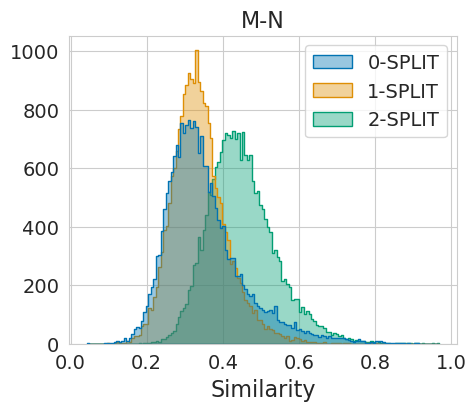

mono_v
avg sims by split:
0-split 0.5908
1-split 0.57
2-split 0.6549


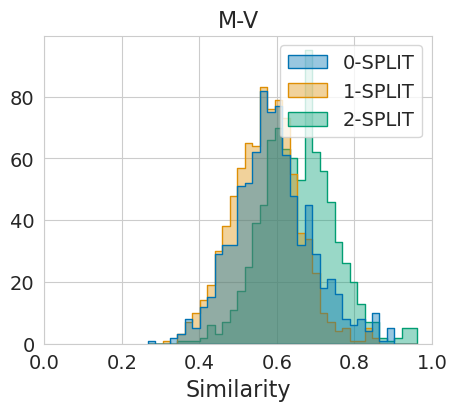

poly_n
avg sims by split:
0-split 0.4302
1-split 0.4262
2-split 0.5157


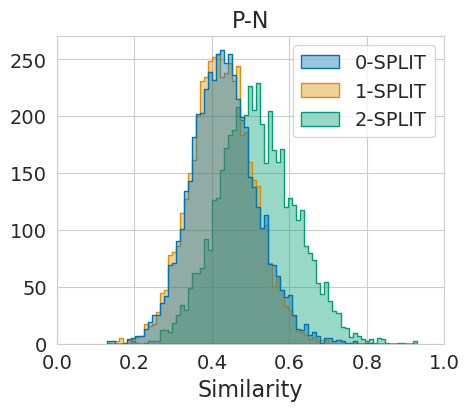

poly_v
avg sims by split:
0-split 0.5573
1-split 0.5259
2-split 0.6023


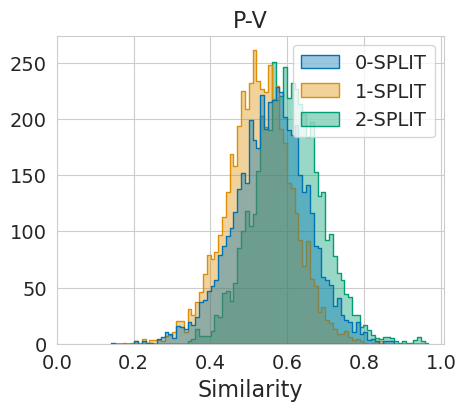

In [28]:

for dn in dataset_names:
    print(dn)
    mp, pos = dn.split("_")
    _ = plot_prediction_histogram(original_datasets[mp][pos], all_results[mp][pos], dn,  best_layers[mp][pos],
                              representation_type='bert', strategy='average', subset="", gold=False)    
    

Same plots for wup_similarity instead of predictions

mono_n
avg sims by split:
0-split 0.4742
1-split 0.4717
2-split 0.4715


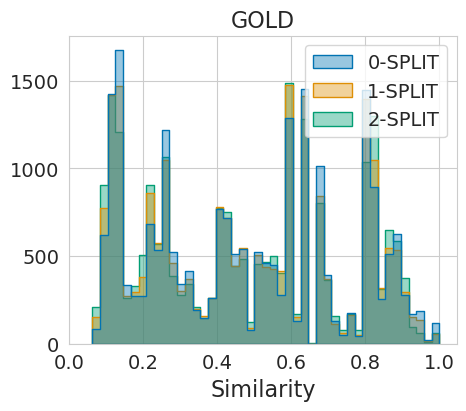

mono_v
avg sims by split:
0-split 0.472
1-split 0.4737
2-split 0.4811


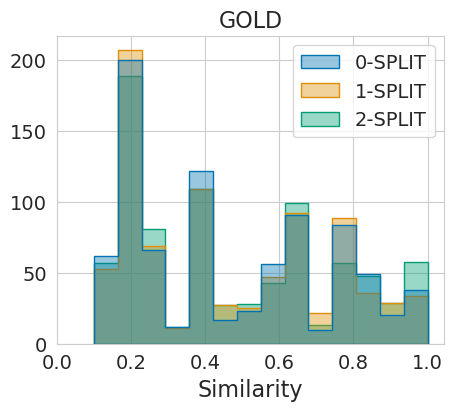

poly_n
avg sims by split:
0-split 0.4876
1-split 0.4834
2-split 0.4821


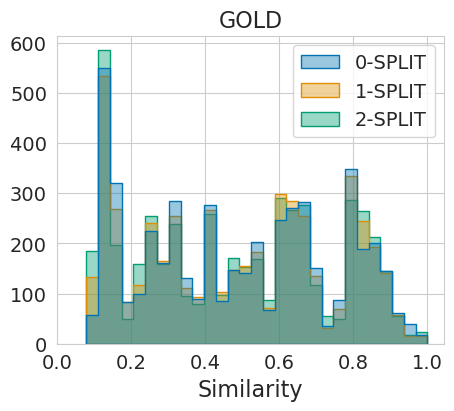

poly_v
avg sims by split:
0-split 0.4885
1-split 0.4832
2-split 0.4857


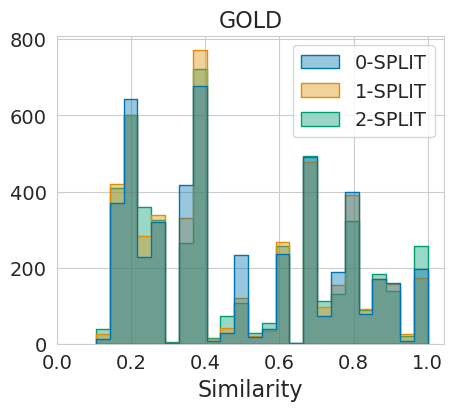

In [29]:

for dn in dataset_names:
    print(dn)
    mp, pos = dn.split("_")
    _ = plot_prediction_histogram(original_datasets[mp][pos], all_results[mp][pos], dn, gold=True)

# Table 12: few vs many subwords

In [30]:


def analysis_num_target_pieces(original_dataset, results, dataset_name, best_layers, representation_type="bert", strategy="average", subset="", show_plots=True):        
    short_name = long_to_short_model_name[representation_type]
    method = (dataset_name, representation_type, strategy, subset)
    best_layers = best_layers[method] 
    all_results_here = dict()
    
    predictions_dataset_by_st = dict()
    for st in ['1-split','2-split']: 
        layer = best_layers[st]        
        fn = predictions_dir + dataset_name + "/" + representation_type + "-l" + str(layer) + "_" + strategy + "_predictions.tsv"                    
        predictions_dataset = pd.read_csv(fn, sep="\t")
        predictions_dataset = pd.merge(original_dataset, predictions_dataset, on=["word1","word2"])                
        predictions_dataset = predictions_dataset[predictions_dataset[short_name + '_split_class'] == st]
        predictions_dataset_by_st[st] = predictions_dataset       
    
    # first number is included, second isn't
    halves = {}
    halves['1-split'] = [(3,4),(4,1000)] 
    halves['2-split'] = [(4,6),(6,1000)]     
    

    # calculate number of pieces in each pair
    for st in predictions_dataset_by_st:
        number_target_pieces = []
        for i, r in predictions_dataset_by_st[st].iterrows():
            number_target_pieces.append(len(ast.literal_eval(r[short_name + "_split_word1"])) + len(ast.literal_eval(r[short_name + "_split_word2"]))) # DEBUG            
        predictions_dataset_by_st[st]['number_target_pieces'] = number_target_pieces  
            
        
    results_to_plot = dict()
    results_here = []
    for st in ['1-split','2-split']: 
        results_to_plot[st] = []        
        
        data = predictions_dataset_by_st[st]
        for i, half in enumerate(halves[st]): 
            half1, half2 = half            
            new_subset = data[(data['number_target_pieces'] >= half1) &(data['number_target_pieces'] < half2)]            
            r, p = spearmanr(new_subset['wup_similarity'], new_subset['predictions']) #, nan_policy="omit") 
            halfname = '-' if i == 0 else '+'
            results_to_plot[st].append({"Spearman's rho":r, "half":halfname})
            results_here.append({'split-type':st, '# subwords':halfname, "Spearman's rho":np.round(r,2), '# pairs': len(new_subset)})
                
                
        if show_plots:
            plt.figure(figsize=(4,3))
            cname = "orange" if st == "1-split" else "green"
            cs = sns.light_palette(cname, n_colors=4)[1:3]              
            results_to_plot_final = pd.DataFrame(results_to_plot[st])
            ax = sns.barplot(x="half", y="Spearman's rho", data=results_to_plot_final, palette=cs) 
            ax.set_title(method_to_legend_name(method) + " " + st.upper(), fontsize=15)
            plt.xlabel("# of subwords", fontsize=13)
            plt.ylabel("Spearman's rho", fontsize=13)
            plt.ylim(0, 0.65)
            plt.tick_params(axis='both', which='major', labelsize=14)
            plt.show()
            
    return pd.DataFrame(results_here)



In [31]:
show_plots = False

for dn in dataset_names:
    print("**********", dn.upper(), "**********")
    mp, pos = dn.split("_")
    
    print("BERT (AVG)")
    res = analysis_num_target_pieces(original_datasets[mp][pos], all_results[mp][pos], dn, best_layers[mp][pos], representation_type="bert", strategy="average", subset="", show_plots=show_plots)        
    display(res)
    print("ELECTRA (AVG)")
    res = analysis_num_target_pieces(original_datasets[mp][pos], all_results[mp][pos], dn, best_layers[mp][pos], representation_type="google#electra-base-discriminator", strategy="average", subset="", show_plots=show_plots)
    display(res)    
    print("XLNET (AVG)")
    res = analysis_num_target_pieces(original_datasets[mp][pos], all_results[mp][pos], dn, best_layers[mp][pos], representation_type="xlnet-base-cased", strategy="average", subset="", show_plots=show_plots)
    display(res)
    


********** MONO_N **********
BERT (AVG)


,split-type,# subwords,Spearman's rho,# pairs
0,1-split,-,0.41,10533
1,1-split,+,0.42,11963
2,2-split,-,0.37,11572
3,2-split,+,0.49,10928


ELECTRA (AVG)


,split-type,# subwords,Spearman's rho,# pairs
0,1-split,-,0.42,10533
1,1-split,+,0.42,11963
2,2-split,-,0.44,11572
3,2-split,+,0.48,10928


XLNET (AVG)


,split-type,# subwords,Spearman's rho,# pairs
0,1-split,-,0.48,12162
1,1-split,+,0.45,13322
2,2-split,-,0.46,13320
3,2-split,+,0.49,16523


********** MONO_V **********
BERT (AVG)


,split-type,# subwords,Spearman's rho,# pairs
0,1-split,-,0.33,418
1,1-split,+,0.36,432
2,2-split,-,0.35,532
3,2-split,+,0.51,318


ELECTRA (AVG)


,split-type,# subwords,Spearman's rho,# pairs
0,1-split,-,0.37,418
1,1-split,+,0.36,432
2,2-split,-,0.31,532
3,2-split,+,0.44,318


XLNET (AVG)


,split-type,# subwords,Spearman's rho,# pairs
0,1-split,-,0.37,422
1,1-split,+,0.32,611
2,2-split,-,0.35,400
3,2-split,+,0.42,473


********** POLY_N **********
BERT (AVG)


,split-type,# subwords,Spearman's rho,# pairs
0,1-split,-,0.34,2906
1,1-split,+,0.36,2094
2,2-split,-,0.36,3578
3,2-split,+,0.40,1422


ELECTRA (AVG)


,split-type,# subwords,Spearman's rho,# pairs
0,1-split,-,0.38,2906
1,1-split,+,0.33,2094
2,2-split,-,0.43,3578
3,2-split,+,0.42,1422


XLNET (AVG)


,split-type,# subwords,Spearman's rho,# pairs
0,1-split,-,0.38,3134
1,1-split,+,0.39,2875
2,2-split,-,0.49,3006
3,2-split,+,0.42,2343


********** POLY_V **********
BERT (AVG)


,split-type,# subwords,Spearman's rho,# pairs
0,1-split,-,0.32,2796
1,1-split,+,0.36,2204
2,2-split,-,0.34,3535
3,2-split,+,0.31,1465


ELECTRA (AVG)


,split-type,# subwords,Spearman's rho,# pairs
0,1-split,-,0.28,2796
1,1-split,+,0.31,2204
2,2-split,-,0.32,3535
3,2-split,+,0.30,1465


XLNET (AVG)


,split-type,# subwords,Spearman's rho,# pairs
0,1-split,-,0.35,2790
1,1-split,+,0.35,3216
2,2-split,-,0.35,1779
3,2-split,+,0.36,1605


# Table 13: omitting the first (o1) or the last (oL) token

In [32]:
def characterize_ml_word(ml_segmentation):    
    ''' this function counts the roots and affixes in a word to determine if it is simple, a derived word, a compound...
    # a word can be:    
    # ROOT: single root ("simple")
    # DERIVATION: one root and one affix ("derivation-pre", "derivation-suf", "derivation-both")
    # COMPOUND: +1 root ("compound")
    # COMBINED: +1 root and some affix ("mixed-pre","mixed-suf","mixed-both")
    '''    
    
    if not ml_segmentation:
        return None
    plus_one_root = False
    has_prefix = False
    has_suffix = False
    try:
        num_roots = ml_segmentation.count("{")
    except TypeError:
        pdb.set_trace()
    num_prefixes = int(ml_segmentation.count("<") / 2) 
    num_suffixes = int(ml_segmentation.count(">") / 2) 
    if num_roots == 1:
        plus_one_root = False
    else:
        plus_one_root = True
    if num_prefixes > 0:
        has_prefix = True
    else:
        has_prefix = False
    if num_suffixes > 0:
        has_suffix = True
    else:
        has_suffix = False
        
    if not plus_one_root and not has_prefix and not has_suffix:
        return "simple"
    elif plus_one_root and not has_prefix and not has_suffix:
        return "compound"
    elif plus_one_root and (has_prefix or has_suffix):
        if has_prefix and has_suffix:
            return "mixed-both"
        elif has_prefix and not has_suffix:
            return "mixed-pre"
        elif not has_prefix and has_suffix:
            return "mixed-suf"        
    elif not plus_one_root and (has_prefix or has_suffix):
        if has_prefix and has_suffix:
            return "derivation-both"
        elif has_prefix and not has_suffix:
            return "derivation-pre"
        elif not has_prefix and has_suffix:
            return "derivation-suf"        
        
    
    
    

In [33]:
simple_pairs = []
for mp in original_datasets:
    for pos in original_datasets[mp]:
        for i, r in original_datasets[mp][pos].iterrows():           
            if characterize_ml_word(gold_actual_segmentation_ml.get(r['word1'])) == "simple" and characterize_ml_word(gold_actual_segmentation_ml.get(r['word2'])) == "simple":
                simple_pairs.append((r['word1'], r['word2']))      


In [34]:


def compare_omitstrategies_by_numpieces_simplexes(original_dataset, results, best_layers, simple_pairs, dataset_name="", representation_type="bert"):        
    results_to_plot = []
    halves = dict()    
    halves['1-split'] = [(3,4),(4,1000)]
    halves['2-split'] = [(4,6),(6,1000)]    
    short_name = long_to_short_model_name[representation_type]        
    all_results_here = dict() 
    control_pairs = []
    methods = []
    
    for strategy in ["average","avg-omitfirst","avg-omitlast"]:
        methods.append((dataset_name,representation_type, strategy,""))    
   
    for method in methods:            
        _, rep, strategy, subset = method        
        predictions_dataset_by_st = dict()               
        res = results[(results["representation_type"] == rep) & (results["strategy"] == strategy)]
        
        for st in ['1-split','2-split']:            
            layer = best_layers[method][st] 
            fn = predictions_dir + dataset_name + "/" + rep + "-l" + str(layer) + "_" + strategy + "_predictions.tsv"                        
            predictions_dataset = pd.read_csv(fn, sep="\t")
            predictions_dataset = pd.merge(original_dataset, predictions_dataset, on=["word1","word2"])
            predictions_dataset_by_st[st] = predictions_dataset            
        
        for st in predictions_dataset_by_st:
            number_target_pieces = []
            for i, r in predictions_dataset_by_st[st].iterrows():                
                number_target_pieces.append(len(ast.literal_eval(r[short_name + "_split_word1"])) + len(ast.literal_eval(r[short_name + "_split_word2"]))) # DEBUG
            predictions_dataset_by_st[st]['number_target_pieces'] = number_target_pieces            
            
        for st in predictions_dataset_by_st: 
            all_results_here[st] = dict()
            subset_data = predictions_dataset_by_st[st][predictions_dataset_by_st[st][short_name + '_split_class'] == st]                                

            for i, half in enumerate(halves[st]):
                half1, half2 = half              
                halfname = '-' if i == 0 else '+'
                new_subset = subset_data[(subset_data['number_target_pieces'] >= half1) &(subset_data['number_target_pieces'] < half2)]                
                new_subset = pd.DataFrame([r for i, r in new_subset.iterrows() if (r['word1'], r['word2']) in simple_pairs])
                 
                r, p = spearmanr(new_subset['wup_similarity'], new_subset['predictions'])         
           
                results_to_plot.append({"Spearman's rho":np.round(r,2), "# subwords":halfname,"split-type":st, 'methodname':method_to_legend_name(method),  '# pairs': len(new_subset) })                           
                    
    
    for st in ['1-split','2-split']:
        for_plot = pd.DataFrame([x for x in results_to_plot if x['split-type'] == st])
        
        plt.figure(figsize=(5,3))

        ax = sns.barplot(x="# subwords", y="Spearman's rho", hue="methodname", data=for_plot, palette=sns.color_palette('colorblind')) #, width=0.6)
        plt.legend(fontsize=14, bbox_to_anchor=(0., -.11, 1., -.11), ncol=4) 

        plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6])
        plt.xlabel("# of subwords", fontsize=15)
        plt.ylabel("Spearman's rho", fontsize=14)
        plt.tick_params(axis="y", labelsize=12, which='major')
        plt.tick_params(axis="x", labelsize=14, which='major')
        plt.title(st.upper(),  fontsize=16.5)


    plt.show()    
        
    return pd.DataFrame(results_to_plot)



********** mono_n **********


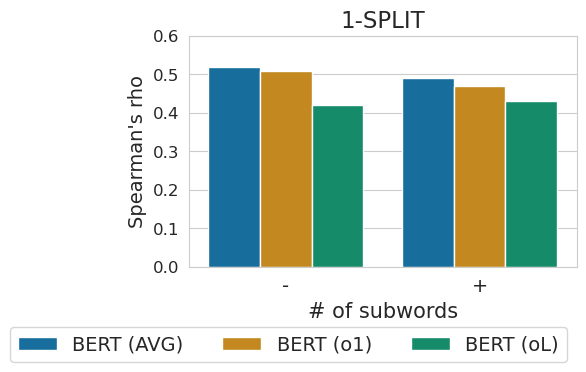

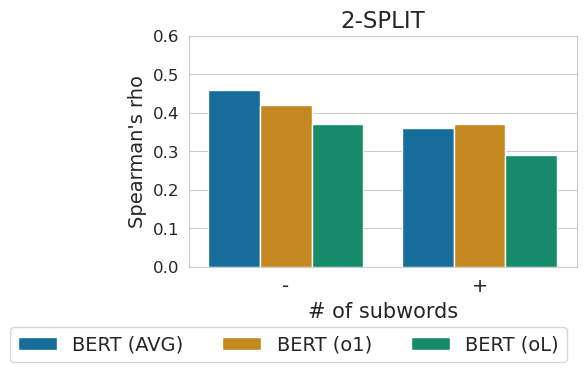

,Spearman's rho,# subwords,split-type,methodname,# pairs
0,0.52,-,1-split,BERT (AVG),1102
1,0.49,+,1-split,BERT (AVG),762
2,0.46,-,2-split,BERT (AVG),409
3,0.36,+,2-split,BERT (AVG),144
4,0.51,-,1-split,BERT (o1),1102
5,0.47,+,1-split,BERT (o1),762
6,0.42,-,2-split,BERT (o1),409
7,0.37,+,2-split,BERT (o1),144
8,0.42,-,1-split,BERT (oL),1102
9,0.43,+,1-split,BERT (oL),762


********** poly_n **********


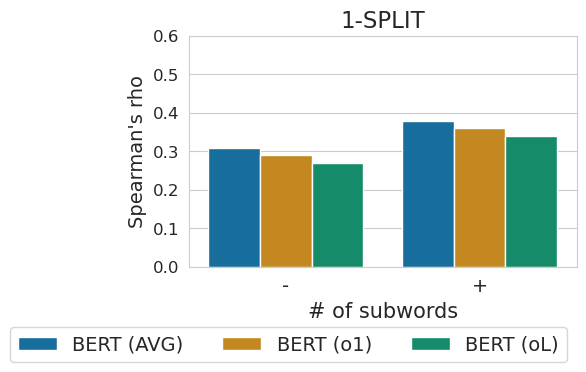

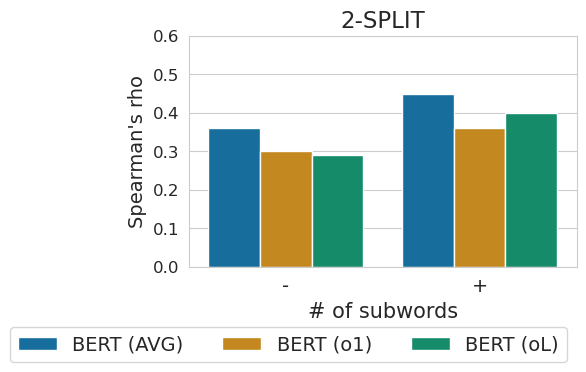

,Spearman's rho,# subwords,split-type,methodname,# pairs
0,0.31,-,1-split,BERT (AVG),605
1,0.38,+,1-split,BERT (AVG),300
2,0.36,-,2-split,BERT (AVG),331
3,0.45,+,2-split,BERT (AVG),70
4,0.29,-,1-split,BERT (o1),605
5,0.36,+,1-split,BERT (o1),300
6,0.30,-,2-split,BERT (o1),331
7,0.36,+,2-split,BERT (o1),70
8,0.27,-,1-split,BERT (oL),605
9,0.34,+,1-split,BERT (oL),300


********** poly_v **********


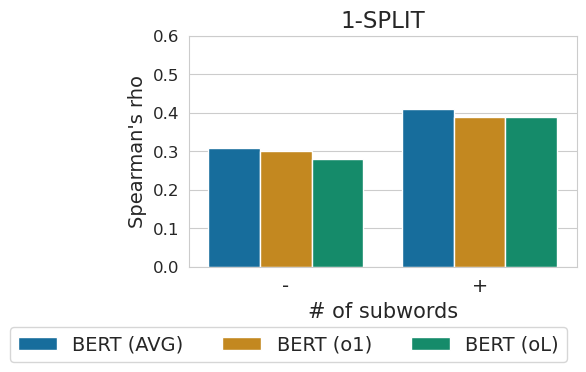

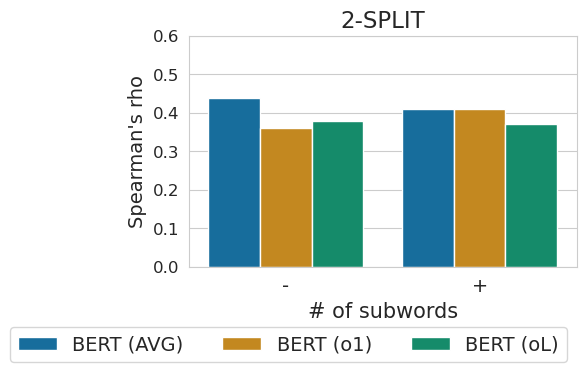

,Spearman's rho,# subwords,split-type,methodname,# pairs
0,0.31,-,1-split,BERT (AVG),1231
1,0.41,+,1-split,BERT (AVG),547
2,0.44,-,2-split,BERT (AVG),831
3,0.41,+,2-split,BERT (AVG),105
4,0.30,-,1-split,BERT (o1),1231
5,0.39,+,1-split,BERT (o1),547
6,0.36,-,2-split,BERT (o1),831
7,0.41,+,2-split,BERT (o1),105
8,0.28,-,1-split,BERT (oL),1231
9,0.39,+,1-split,BERT (oL),547


In [35]:
for dn in dataset_names:        
    if dn == "mono_v":
        continue
    print("**********", dn, "**********")
    mp, pos = dn.split("_")    
    res = compare_omitstrategies_by_numpieces_simplexes(original_datasets[mp][pos], all_results[mp][pos], best_layers[mp][pos], simple_pairs, dataset_name=dn, representation_type="bert")
    display(res)


# Table 16 (Appendix, results against Fasttext similarities)

In [36]:
ft_res = dict()

best_layers_fasttext = dict()

for dn in dataset_names:  
    print(dn)    
    mp, pos = dn.split("_")       
    
    best_layers_fasttext[dn] = dict()
    subset = "fasttext-all-GS"
    
    for method in all_methods[mp][pos]:           
        if not "context" in method['representation_type'] and not "omit" in method['strategy']:
            bls = find_best_layer_by_split(all_results[mp][pos], dataset_name=method['dataset_name'], representation_type=method['representation_type'], strategy=method['strategy'], subset=subset)    
            best_layers_fasttext[dn][(method['dataset_name'], method['representation_type'], method['strategy'], subset)] = bls
            
    ft_res[dn] = plot_comparison_best_layer(all_results[mp][pos], best_layers_fasttext[dn])   

    ftresdn = pd.DataFrame(ft_res[dn]) 
    ftresdn = ftresdn.round({"Spearman's rho":2})
   

    display(ftresdn)
  

mono_n


,representation_type,strategy,Spearman's rho,layer,split-type
584,bert,average,0.65,3,0-split
369,bert,average,0.45,5,1-split
506,bert,average,0.46,10,2-split
464,bert,waverage,0.65,3,0-split
525,bert,waverage,0.43,6,1-split
402,bert,waverage,0.44,10,2-split
396,bert,longest,0.65,3,0-split
341,bert,longest,0.32,8,1-split
322,bert,longest,0.29,10,2-split
676,bert-flota-3,average,0.65,3,0-split


mono_v


,representation_type,strategy,Spearman's rho,layer,split-type
580,bert,average,0.66,2,0-split
569,bert,average,0.45,12,1-split
570,bert,average,0.53,12,2-split
392,bert,waverage,0.66,2,0-split
477,bert,waverage,0.44,12,1-split
478,bert,waverage,0.50,12,2-split
420,bert,longest,0.66,2,0-split
453,bert,longest,0.36,12,1-split
454,bert,longest,0.38,12,2-split
816,bert-flota-3,average,0.66,2,0-split


poly_n


,representation_type,strategy,Spearman's rho,layer,split-type
320,bert,average,0.63,2,0-split
593,bert,average,0.46,12,1-split
594,bert,average,0.52,12,2-split
312,bert,waverage,0.63,2,0-split
361,bert,waverage,0.45,12,1-split
362,bert,waverage,0.51,12,2-split
516,bert,longest,0.63,2,0-split
413,bert,longest,0.37,12,1-split
414,bert,longest,0.38,12,2-split
920,bert-flota-3,average,0.63,2,0-split


poly_v


,representation_type,strategy,Spearman's rho,layer,split-type
320,bert,average,0.63,2,0-split
593,bert,average,0.46,12,1-split
594,bert,average,0.52,12,2-split
312,bert,waverage,0.63,2,0-split
361,bert,waverage,0.45,12,1-split
362,bert,waverage,0.51,12,2-split
516,bert,longest,0.63,2,0-split
413,bert,longest,0.37,12,1-split
414,bert,longest,0.38,12,2-split
920,bert-flota-3,average,0.63,2,0-split


In [37]:
for dn in ["mono_n","mono_v","poly_n","poly_v"]: 
    print("******", dn.upper(), "*******")
    mp, pos = dn.split("_")
    cs_bert = Counter(original_datasets[mp][pos]['bert_split_class'])    
    cs_xlnet = Counter(original_datasets[mp][pos]['xlnet_split_class'])    
    best_layers_some_methods = dict()
    subset = "fasttext-all-GS"    
    for method in all_methods[mp][pos]:               
        rs = dict()
        if not "context" in method['representation_type'] and not "omit" in method['strategy']:             
            bls = best_layers_fasttext[dn][(method['dataset_name'], method['representation_type'], method['strategy'], subset)]
            for i, r in all_results[mp][pos].iterrows():
                if r['representation_type'] == method['representation_type'] and r['strategy'] == method['strategy'] and r['layer'] == bls[r['split-type']]:
                    rs[r['split-type']] = r['fasttext-all-GS_r'] 
            print(method['representation_type'], method['strategy'])
            if "xlnet" in method['representation_type']:
                calculate_significance(rs, cs_xlnet)
            else:
                calculate_significance(rs, cs_bert)    
                
            print()

****** MONO_N *******
bert average
p value for the comparison 0-split vs 1-split is significant
p value for the comparison 2-split vs 0-split is significant

bert waverage
p value for the comparison 0-split vs 1-split is significant
p value for the comparison 1-split vs 2-split is significant
p value for the comparison 2-split vs 0-split is significant

bert longest
p value for the comparison 0-split vs 1-split is significant
p value for the comparison 1-split vs 2-split is significant
p value for the comparison 2-split vs 0-split is significant

bert-flota-3 average
p value for the comparison 0-split vs 1-split is significant
p value for the comparison 1-split vs 2-split is significant
p value for the comparison 2-split vs 0-split is significant

bert-flota-3 waverage
p value for the comparison 0-split vs 1-split is significant
p value for the comparison 1-split vs 2-split is significant
p value for the comparison 2-split vs 0-split is significant

bert-flota-3 longest
p value for the

xlnet-base-cased average
p value for the comparison 0-split vs 1-split is significant
p value for the comparison 1-split vs 2-split is significant
p value for the comparison 2-split vs 0-split is significant

xlnet-base-cased waverage
p value for the comparison 0-split vs 1-split is significant
p value for the comparison 2-split vs 0-split is significant

xlnet-base-cased longest
p value for the comparison 0-split vs 1-split is significant
p value for the comparison 1-split vs 2-split is significant
p value for the comparison 2-split vs 0-split is significant

characterbert average
p value for the comparison 2-split vs 0-split is significant

